# Obtaining and cleaning Data

In [250]:
import yfinance as yf
import pandas as pd
from datetime import date, timedelta

In [252]:
# parameters
tickers = ["HDFCBANK.NS", "ICICIBANK.NS"]

end = date(2025, 10, 1)
start = date(end.year-7, end.month, end.day)   # 5 yr data (from 1 oct 2020)

In [254]:
# fetch data

df = yf.download(tickers, start=start.isoformat(), end=(end + timedelta(days=1)).isoformat(), progress=False, auto_adjust=False)
adj = df.filter(like="Adj Close")      #older --adj = df["Adj Close"].copy()

In [256]:
print("date range downloaded:", adj.index.min().date(), "to", adj.index.max().date())
print("shape:", adj.shape)
# print(adj.tail(5))

date range downloaded: 2018-10-01 to 2025-10-01
shape: (1730, 2)


In [258]:
# alignment and cleaning
adj = adj.dropna(how="all")
adj = adj.bfill()
adj = adj.dropna()

In [262]:
# normalize and overwrite CSV with clean single-row header
# (run where `adj` is the MultiIndex DataFrame you fetched)
cols = [('Adj Close','HDFCBANK.NS'), ('Adj Close','ICICIBANK.NS')]
# keep only adj close columns (safe)
adj_clean = adj.loc[:, cols].copy()
adj_clean.columns = ['HDFCBANK.NS', 'ICICIBANK.NS']   # single-level names
adj_clean.to_csv("hdfc_icici_adjclose_clean.csv", index=True)
print("Clean CSV:", "hdfc_icici_adjclose_clean.csv")


Clean CSV: hdfc_icici_adjclose_clean.csv


# Spread and Z-score

In [233]:
import matplotlib.pyplot as plt

In [235]:
lookback = 30

ratio = adj['Adj Close', 'HDFCBANK.NS'] / adj['Adj Close', 'ICICIBANK.NS']   # adj_close HDFC / adj_close ICICI
mean = ratio.rolling(lookback).mean()
std = ratio.rolling(lookback).std()

zscore = (ratio - mean) / std
print(zscore.tail(5))

Date
2025-09-25    0.620523
2025-09-26    1.472395
2025-09-29    2.855675
2025-09-30    2.670951
2025-10-01    2.159699
dtype: float64


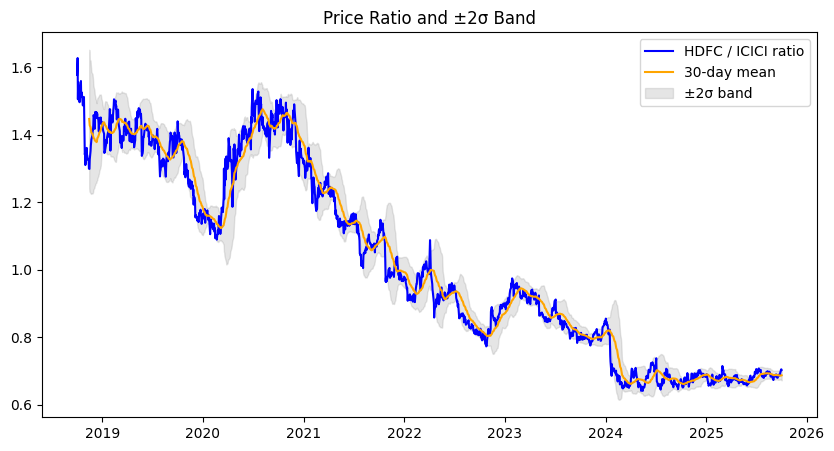

In [237]:
plt.figure(figsize=(10,5))
plt.plot(ratio, label='HDFC / ICICI ratio', color='blue')
plt.plot(mean, label='30-day mean', color='orange')
plt.fill_between(ratio.index, (mean + 2*std), (mean - 2*std),
                 color='gray', alpha=0.2, label='±2σ band')
plt.legend()
plt.title('Price Ratio and ±2σ Band')
plt.show()


# Generate trade signals

In [247]:
signals = pd.DataFrame(index=zscore.index)
signals['zscore'] = zscore
signals['long_ratio'] = zscore < -2       # Buy HDFC / Sell ICICI
signals['short_ratio'] = zscore > 2       # Sell HDFC / Buy ICICI
signals['exit'] = abs(zscore) < 0.5       # Close positions when near mean

# print(signals.tail(10))

              zscore  long_ratio  short_ratio   exit
Date                                                
2025-09-18 -0.122671       False        False   True
2025-09-19  0.258100       False        False   True
2025-09-22  0.073612       False        False   True
2025-09-23 -0.126559       False        False   True
2025-09-24  0.158002       False        False   True
2025-09-25  0.620523       False        False  False
2025-09-26  1.472395       False        False  False
2025-09-29  2.855675       False         True  False
2025-09-30  2.670951       False         True  False
2025-10-01  2.159699       False         True  False
